In [1]:
import os
import re
import cv2
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# //TODO::WTF::

IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            tokens = line.strip().split(",") 
            if len(tokens) == 2:
                image_id, caption = tokens
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append(caption)
    return captions_dict

def display_images_with_captions(images_dir, captions_dict, num_images=3, image_size=(224, 224)):
    images = list(captions_dict.keys())

    if len(images) < num_images:
        raise ValueError(f"Requested {num_images} images, but only {len(images)} available.")
    
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10 * num_images, 10))
    
    for i, image in enumerate(selected_images):
        img_path = os.path.join(images_dir, image)
        img = Image.open(img_path)
        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        captions = "\n".join(captions_dict[image]) 
        plt.title(captions, fontsize=10, loc='center', wrap=True)
    
    plt.tight_layout()
    plt.show()

def plot_training_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_results(model, dataloader, tokenizer, num_images=5):
    for images, _ in dataloader:
        images = images[:num_images].to(device)
        captions = [generate_caption(model, image, tokenizer) for image in images]

        plt.figure(figsize=(5, num_images * 5))

        for i in range(num_images):
            ax = plt.subplot(num_images, 1, i + 1)
            ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            ax.axis("off")  # Remove axes
            ax.set_title(captions[i], fontsize=12, wrap=True)

        plt.tight_layout()
        plt.show()
        break

# def display_random_images_with_captions(images_dir, captions_dict, num_images=5):
#     selected_images = random.sample(list(captions_dict.keys()), num_images)
#     plt.figure(figsize=(15, 10))

#     for i, image_id in enumerate(selected_images):
#         img_path = f"{images_dir}/{image_id}"
#         img = Image.open(img_path)

#         plt.subplot(num_images, 1, i + 1)
#         # plt.subplot(1, num_images, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(captions_dict[image_id], fontsize=10)
    
#     plt.tight_layout()
#     plt.show()
        
def plot_caption_length_variation(captions_dict):
    lengths = []
    for captions in captions_dict.values():
        lengths.extend([len(caption.split()) for caption in captions])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(lengths)), lengths, alpha=0.5)
    plt.title("Variation in Caption Lengths", fontsize=14)
    plt.xlabel("Caption Index", fontsize=12)
    plt.ylabel("Caption Length (Number of Words)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_word_frequency_histogram(captions_dict, top_n=20):
    word_counter = Counter()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            word_counter.update(preprocessed_caption.split())
    
    most_common_words = word_counter.most_common(top_n)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {top_n} Most Frequent Words", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    flattened_captions = []
    for image_id, captions in captions_dict.items():
        for caption in captions:
            flattened_captions.append((image_id, caption))

    random.seed(random_seed)
    random.shuffle(flattened_captions)

    total_samples = len(flattened_captions)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_samples = flattened_captions[:train_end]
    val_samples = flattened_captions[train_end:val_end]
    test_samples = flattened_captions[val_end:]

    train_captions = {image_id: [] for image_id, _ in train_samples}
    for image_id, caption in train_samples:
        train_captions[image_id].append(caption)

    val_captions = {image_id: [] for image_id, _ in val_samples}
    for image_id, caption in val_samples:
        val_captions[image_id].append(caption)

    test_captions = {image_id: [] for image_id, _ in test_samples}
    for image_id, caption in test_samples:
        test_captions[image_id].append(caption)

    return train_captions, val_captions, test_captions

def save_captions_to_json(captions, filepath):
    with open(filepath, 'w') as file:
        json.dump(captions, file, ensure_ascii=False, indent=4)

In [4]:
captions_dict = load_captions(CAPTIONS_FILE)
display_images_with_captions(IMAGES_DIR, captions_dict)

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove numbers
    return text.strip()

def build_tokenizer(captions_dict):
    special_tokens = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    word_to_index = defaultdict(lambda: special_tokens["<unk>"], special_tokens.copy())
    
    # Tokenize captions and build vocabulary
    vocab = set()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            vocab.update(preprocessed_caption.split())
    
    # Add vocabulary words to the tokenizer
    for idx, word in enumerate(sorted(vocab), start=len(special_tokens)):
        word_to_index[word] = idx
    
    return dict(word_to_index)

def save_tokenizer_to_json(tokenizer, filepath):
    with open(filepath, 'w') as file:
        json.dump(tokenizer, file, ensure_ascii=False, indent=4)

def caption_tokenizer(caption, word_to_index, max_length=50): # //TODO::WTF::
    tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
    token_ids = [word_to_index.get(word, word_to_index["<unk>"]) for word in tokens]
    token_ids = token_ids[:max_length]
    token_ids += [word_to_index["<pad>"]] * (max_length - len(token_ids))
    return torch.tensor(token_ids)

In [6]:
word_to_index_tokenizer = build_tokenizer(captions_dict)

TOKENIZER_FILE = "tokenizer.json"
save_tokenizer_to_json(word_to_index_tokenizer, TOKENIZER_FILE)

print(f"Word to Index Tokenizer saved to {TOKENIZER_FILE}. Total tokens: {len(word_to_index_tokenizer)}")

Tokenizer saved to tokenizer.json. Total tokens: 8478


In [8]:
train_captions, val_captions, test_captions = split_dataset(captions_dict)

save_captions_to_json(train_captions, "train_captions.json")
save_captions_to_json(val_captions, "val_captions.json")
save_captions_to_json(test_captions, "test_captions.json")

print("Dataset split complete:")
print(f"Training: {len(train_captions)} images")
print(f"Validation: {len(val_captions)} images")
print(f"Test: {len(test_captions)} images")

Dataset split complete:
Training: 8084 images
Validation: 3166 images
Test: 3119 images


In [11]:
# display_random_images_with_captions(IMAGES_DIR, captions_dict, num_images=5)

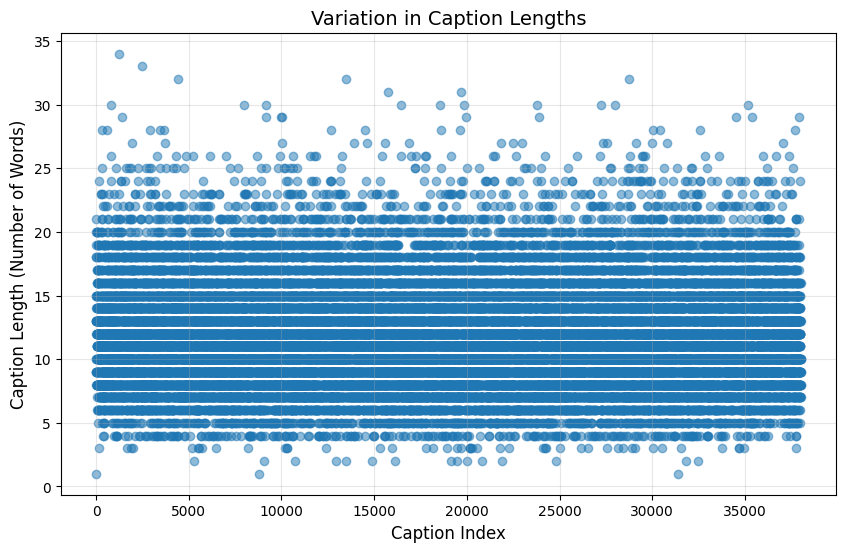

In [12]:
plot_caption_length_variation(captions_dict)

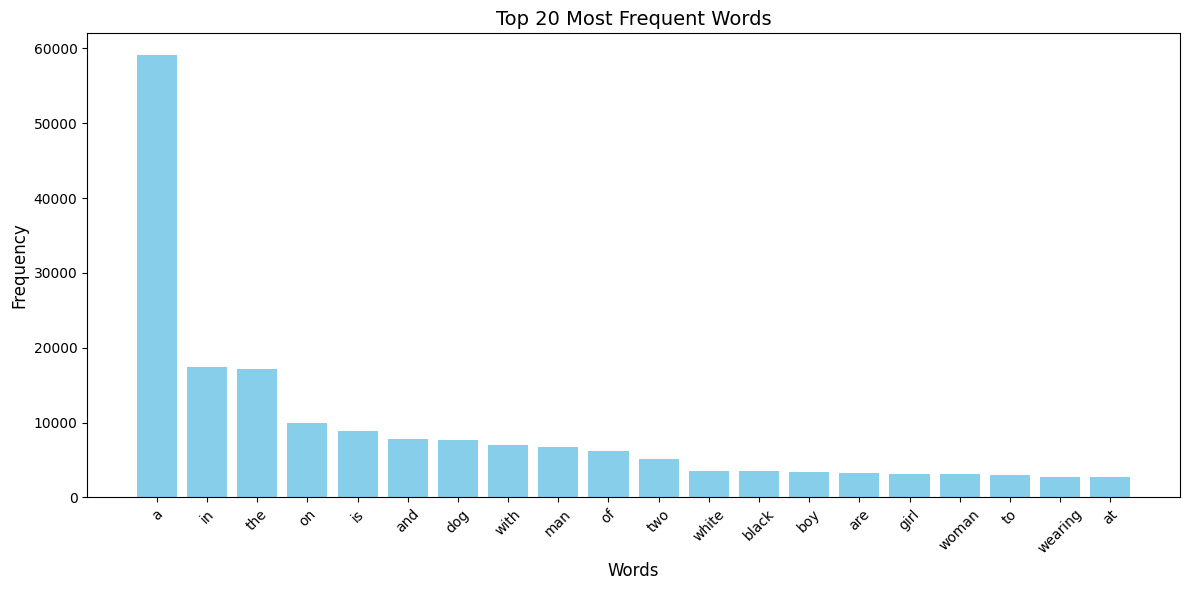

In [13]:
plot_word_frequency_histogram(captions_dict, top_n=20)

In [14]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, tokenizer=None, max_seq_length=50):
        with open(captions_file, 'r') as file:
            self.captions_dict = json.load(file)

        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.image_caption_pairs = []
        for image_id, captions in self.captions_dict.items():
            image_path = os.path.join(images_dir, image_id)
            if os.path.exists(image_path):
                for caption in captions:
                    self.image_caption_pairs.append((image_id, caption))
        
        random.shuffle(self.image_caption_pairs)
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_id, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.images_dir, image_id)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        if self.tokenizer:
            caption = self.tokenizer(caption)

        return image, caption

def create_dataloaders(images_dir, train_captions_file, val_captions_file, test_captions_file, batch_size, tokenizer):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = FlickrDataset(train_captions_file, images_dir, transform=transform_train, tokenizer=tokenizer)
    val_dataset = FlickrDataset(val_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    test_dataset = FlickrDataset(test_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [15]:
with open(TOKENIZER_FILE, "r") as file:
    word_to_index = json.load(file)

train_loader, val_loader, test_loader = create_dataloaders(
    IMAGES_DIR,
    "train_captions.json",
    "val_captions.json",
    "test_captions.json",
    BATCH_SIZE,
    lambda caption: caption_tokenizer(caption, word_to_index)
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 951
Validation batches: 119
Testing batches: 119


In [ ]:
PAD_IDX = word_to_index_tokenizer["<pad>"]

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=256):
        super(EncoderCNN, self).__init__()
        # Load pretrained EfficientNet-B0
        self.efficient_net = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Remove the classifier head
        self.efficient_net.classifier = nn.Identity()
        # Global Average Pooling to produce a single vector per image
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # Linear layer to project features to the desired size
        self.fc = nn.Linear(1280, encoded_image_size)

    def forward(self, images):
        features = self.efficient_net.features(images)  # Extract convolutional features
        pooled_features = self.pool(features).squeeze(-1).squeeze(-1)  # Global average pooling
        projected_features = self.fc(pooled_features)  # Reduce dimensionality
        return projected_features  # Final feature vector for the decoder


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # Word embedding layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)  # Final prediction layer
        self.dropout = nn.Dropout(dropout)

        self.encoder_to_hidden = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        batch_size = features.size(0)

        # Project encoder output to LSTM hidden state size
#       h0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        h0 = self.encoder_to_hidden(features).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros_like(h0).to(features.device)  # Initialize cell state with zeros
        embeddings = self.dropout(self.embed(captions))  # (batch_size, seq_len, embed_size)
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)  # (batch_size, seq_len + 1, embed_size)
        hiddens, _ = self.lstm(inputs, (h0, c0))  # (batch_size, seq_len + 1, hidden_size)
        outputs = self.fc(hiddens)  # (batch_size, seq_len + 1, vocab_size)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)  # Extract image features
        outputs = self.decoder(features, captions)  # Generate captions
        return outputs

def masked_cross_entropy_loss(outputs, targets):
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    return loss_fn(outputs.permute(0, 2, 1), targets)  # Permute for [batch_size, vocab_size, seq_len]

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path="checkpoint.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer): # //TODO::WTF:: I don't know how to use till no.
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, loss

def generate_caption(model, image, tokenizer, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))
        caption = ["<sos>"]
        for _ in range(max_length):
            caption_tensor = torch.tensor([tokenizer[word] for word in caption]).unsqueeze(0).to(device)
            outputs = model.decoder(features, caption_tensor)
            predicted_idx = outputs[0, -1].argmax().item()
            predicted_word = list(tokenizer.keys())[list(tokenizer.values()).index(predicted_idx)]
            if predicted_word == "<eos>":
                break
            caption.append(predicted_word)
    return " ".join(caption[1:])

def freeze_encoder_layers(encoder, freeze_all=True, freeze_last_n=None):
    if freeze_all:
        for param in encoder.parameters():
            param.requires_grad = False
    elif freeze_last_n is not None:
        num_layers = len(list(encoder.efficient_net.features.children()))
        for i, child in enumerate(encoder.efficient_net.features.children()):
            if i < num_layers - freeze_last_n:
                for param in child.parameters():
                    param.requires_grad = False

In [ ]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs=50, 
    checkpoint_path="checkpoint.pth", resume=False, patience=5,
    weight_decay=1e-4
):
    model.train()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience-2)

    if resume and os.path.exists(checkpoint_path):
        start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
    else:
        start_epoch = 0
        
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0 

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0
        tepoch = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (images, captions) in enumerate(tepoch):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()

            outputs = model(images, captions[:, :-1])  # Exclude the last word for teacher forcing            
            outputs = outputs[:, :captions.size(1) - 1, :]  # Match target sequence length

            loss = masked_cross_entropy_loss(outputs, captions[:, 1:])  # Exclude <sos> for target TODO::WTF:: what about the first character? it should be excluded too.
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            tepoch.set_postfix(loss=f"{loss.item():.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                outputs = outputs[:, :captions.size(1) - 1, :]
                loss = masked_cross_entropy_loss(outputs, captions[:, 1:])
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)
        # print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 
            save_checkpoint(model, optimizer, epoch + 1, val_loss, checkpoint_path)
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

In [17]:
embed_size = 256
hidden_size = 512
vocab_size = len(word_to_index_tokenizer)  # Tokenizer vocabulary size
num_layers = 2 # //TODO::WTF:: # Based on the paper

encoder = EncoderCNN(encoded_image_size=embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Freeze encoder layers (fine-tuning last 2 layers)
freeze_encoder_layers(encoder, freeze_all=False, freeze_last_n=2) # //TODO::WTF::

In [18]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer
)

Epoch 1, Train Loss: 4.5028


Epoch 1, Validation Loss: 4.1504


Epoch 2, Train Loss: 4.0546


Epoch 2, Validation Loss: 4.0363


Epoch 3, Train Loss: 3.8935


Epoch 3, Validation Loss: 3.8972


Epoch 4, Train Loss: 3.7922


Epoch 4, Validation Loss: 3.8350


Epoch 5, Train Loss: 3.7220


Epoch 5, Validation Loss: 3.7966


Epoch 6, Train Loss: 3.6653


Epoch 6, Validation Loss: 3.7559


Epoch 7, Train Loss: 3.6291


Epoch 7, Validation Loss: 3.7543


Epoch 8, Train Loss: 3.5981


Epoch 8, Validation Loss: 3.7656
No improvement in validation loss for 1 epoch(s).


Epoch 9, Train Loss: 3.5742


Epoch 9, Validation Loss: 3.7789
No improvement in validation loss for 2 epoch(s).


Epoch 10, Train Loss: 3.5524


Epoch 10, Validation Loss: 3.7143


Epoch 11, Train Loss: 3.5343


Epoch 11, Validation Loss: 3.6920


Epoch 12, Train Loss: 3.5179


Epoch 12, Validation Loss: 3.6929
No improvement in validation loss for 1 epoch(s).


Epoch 13, Train Loss: 3.5063


Epoch 13, Validation Loss: 3.6879


Epoch 14, Train Loss: 3.4938


Epoch 14, Validation Loss: 3.6748


Epoch 15, Train Loss: 3.4827


Epoch 15, Validation Loss: 3.6740


Epoch 16, Train Loss: 3.4734


Epoch 16, Validation Loss: 3.6673


Epoch 17, Train Loss: 3.4637


Epoch 17, Validation Loss: 3.6623


Epoch 18, Train Loss: 3.4544


Epoch 18, Validation Loss: 3.6786
No improvement in validation loss for 1 epoch(s).


Epoch 19, Train Loss: 3.4489


Epoch 19, Validation Loss: 3.6688
No improvement in validation loss for 2 epoch(s).


Epoch 20, Train Loss: 3.4415


Epoch 20, Validation Loss: 3.6348


Epoch 21, Train Loss: 3.4355


Epoch 21, Validation Loss: 3.6596
No improvement in validation loss for 1 epoch(s).


Epoch 22, Train Loss: 3.4292


Epoch 22, Validation Loss: 3.6728
No improvement in validation loss for 2 epoch(s).


Epoch 23, Train Loss: 3.4249


Epoch 23, Validation Loss: 3.6365
No improvement in validation loss for 3 epoch(s).


Epoch 24, Train Loss: 3.4173


Epoch 24, Validation Loss: 3.6561
No improvement in validation loss for 4 epoch(s).


Epoch 25, Train Loss: 3.4122


Epoch 25, Validation Loss: 3.6718
No improvement in validation loss for 5 epoch(s).


Epoch 26, Train Loss: 3.4087


Epoch 26, Validation Loss: 3.6565
No improvement in validation loss for 6 epoch(s).


Epoch 27, Train Loss: 3.3286


Epoch 27, Validation Loss: 3.6155


Epoch 28, Train Loss: 3.3127


Epoch 28, Validation Loss: 3.5637


Epoch 29, Train Loss: 3.3065


Epoch 29, Validation Loss: 3.5847
No improvement in validation loss for 1 epoch(s).


Epoch 30, Train Loss: 3.3003


Epoch 30, Validation Loss: 3.5818
No improvement in validation loss for 2 epoch(s).


Epoch 31, Train Loss: 3.2946


Epoch 31, Validation Loss: 3.5798
No improvement in validation loss for 3 epoch(s).


Epoch 32, Train Loss: 3.2904


Epoch 32, Validation Loss: 3.6412
No improvement in validation loss for 4 epoch(s).


Epoch 33, Train Loss: 3.2836


Epoch 33, Validation Loss: 3.6134
No improvement in validation loss for 5 epoch(s).


Epoch 34, Train Loss: 3.2787


Epoch 34, Validation Loss: 3.6302
No improvement in validation loss for 6 epoch(s).


Epoch 35, Train Loss: 3.2266


Epoch 35, Validation Loss: 3.5794
No improvement in validation loss for 7 epoch(s).
Early stopping triggered.


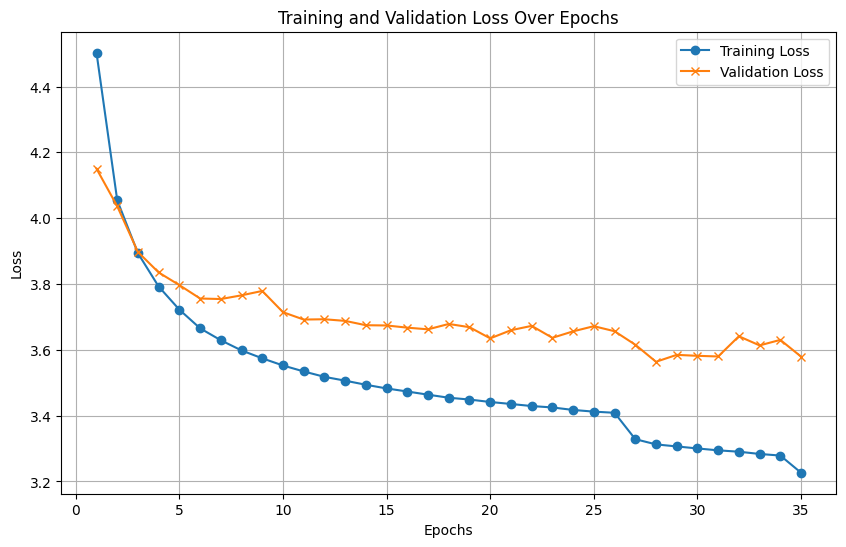

In [19]:
plot_training_losses(train_losses, val_losses)

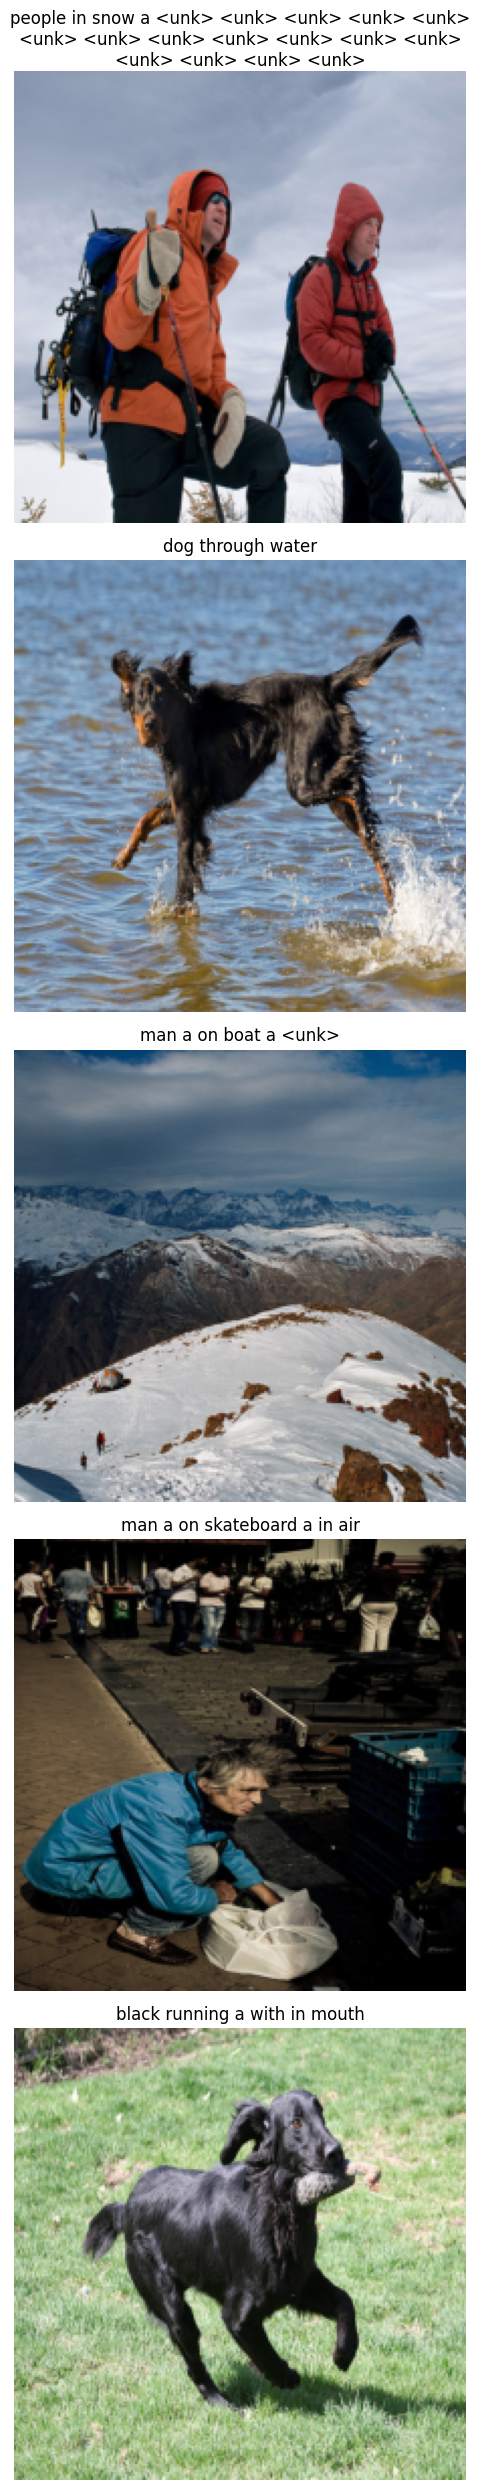

In [21]:
visualize_results(model, test_loader, tokenizer)